<a href="https://colab.research.google.com/github/matthiasweidlich/conf_tutorial/blob/master/03_alignment_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-On Exercise 3: Alignment-based Conformance

In this exercise, we will again take up the real-life event log of a Dutch financial institute. Be reminded that you should be able to clone the repository containing the notebooks and the example data with the code in the next cell. If this does not work, however, you can also download the event log (XES format, please unzip) [here](http://www.win.tue.nl/bpi/doku.php?id=2012:challenge) and then either copy it to your google drive, mount it, and read it from there, or directly upload it using your browser.

Also, further details can be found in the [description of the dataset](http://www.win.tue.nl/bpi/doku.php?id=2012:challenge).

In [1]:
# basic configuration
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# import data from google drive
#from google.colab import drive
#drive.mount('/content/drive')

# direct data upload
#from google.colab import files
#files.upload()

# clone the repository that contains the notebooks and also the data file
!git clone https://github.com/matthiasweidlich/conf_tutorial.git
!pip install pmlab-lite

     |████████████████████████████████| 51kB 2.5MB/s 


## Import Event Log


In [1]:
from pprint import pprint
from pmlab_lite.helper.io import xes

log_file = '/content/conf_tutorial/financial_log.xes' # if not in colab or import from different folder: insert path here
log = xes.import_xes(log_file)

print('Load log with %s traces.' %len(log.traces))

100%|██████████| 13087/13087 [02:45<00:00, 79.17it/s] 


Load log with 13087 traces.


Now import the given log and compute the trace variants of the log along with their frequencies.

In [2]:
trace_variants = {}
for trace in log.get_traces():
    events = []
    for event in trace:
        events.append(event['concept:name'])
    trace_variants[tuple(events)] = trace_variants.get(tuple(events), 0) + 1
    
# print the two most frequent variants
trace_variants_sorted_by_freq = sorted(trace_variants.items(), key=lambda kv: kv[1], reverse=True)
pprint(trace_variants_sorted_by_freq[:2])

[(('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED'), 3429),
 (('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'A_DECLINED',
   'W_Afhandelen leads'),
  1872)]


## Import Process Model

For the log, a process model is given in the form of a Petri net. Such a process model is typically created manually. For this particular example, however, the model has been discovered automatically using the Inductive Miner, applying some noise filtering threshold. 

Note that here, we relabel the silent transitions (label *tau*) so that all transitions are uniquely labelled (e.g., *tau* becomes *tau-x* with x being an id). This is purely a technical consideration as it is required by the code used later.

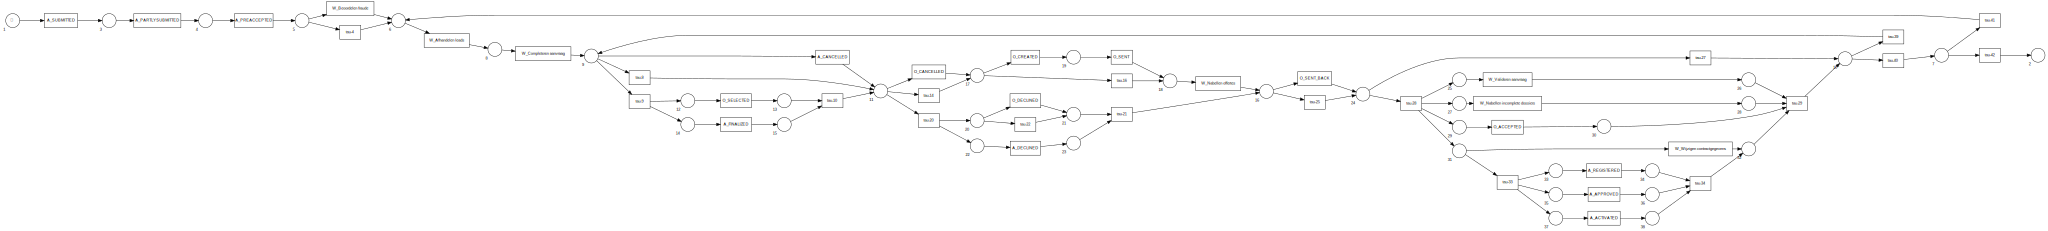

In [3]:
from pmlab_lite.pn import PetriNet 
from pmlab_lite.helper.io import pnml 
from pmlab_lite.helper.viz import dot 

net = PetriNet()
pnml.load(net, "/content/conf_tutorial/financial_log_80_noise.pnml") 

# mark the initial place
net.add_marking(1,1)

# make sure to assign unique labels to silent transitions
t_transitions = dict()
for t in net.transitions['tau']:
    net.transitions['tau' + str(t)] = [t]
net.transitions.pop('tau', None)


# visualise it 
dot.draw_petri_net(net)      

## Alignment Construction

To assess the conformance of the traces of the log with the process model, we next compute optimal alignments between them. To this end, an implementation of the alignment construction based on A* search is used. 

Traces of the same trace variant have equal sets of optimal alignments. We therefore consider the construction of alignments solely for trace variants. The code below computes optimal alignments for the most frequent trace variants.



In [4]:
from pmlab_lite.alignments.a_star import A_Star
from pmlab_lite.pn import SynchronousProduct, TraceNet

# select some most frequent traces
traces = dict()
for k in range(10):
    traces[k] = list(trace_variants_sorted_by_freq[k][0])


trace_net = TraceNet(traces[0])
synchronous_product = SynchronousProduct(net, trace_net)

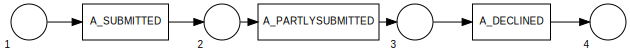

In [5]:
dot.draw_petri_net(trace_net)

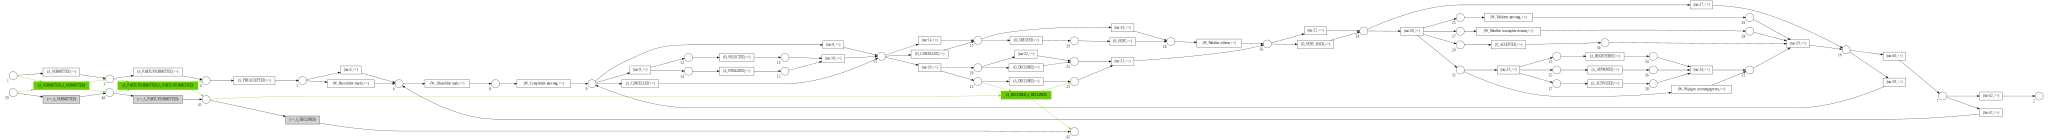

In [6]:
dot.draw_synchronous_product(synchronous_product)

Now, let us have a look at the computed alignments:

In [8]:
alignments = {}
for i in range(10):
  trace = traces[i]
  print('Trace in the log:\n', trace)
  print('Optimal Alignment: ')
  trace_model = TraceNet(trace)
  sp = SynchronousProduct(net, trace_model)
  a = A_Star(sp, trace, heuristic='tl')     #lp not perfect yet, since lstsq does not solve the equation Ax=b s.t. min[c(x)], but only for any x
  a.search()
  print(a.alignment_moves) # or use a.print_alignment()
  alignments[i] = a.alignment_moves
  print('\n')

Trace in the log:
 ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED']
Optimal Alignment: 
[[('A_SUBMITTED', 'A_SUBMITTED'), ('A_PARTLYSUBMITTED', 'A_PARTLYSUBMITTED'), ('A_PREACCEPTED', '>>'), ('W_Afhandelen leads', '>>'), ('W_Completeren aanvraag', '>>'), ('A_DECLINED', 'A_DECLINED')]]


Trace in the log:
 ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_DECLINED', 'W_Afhandelen leads']
Optimal Alignment: 
[[('A_SUBMITTED', 'A_SUBMITTED'), ('A_PARTLYSUBMITTED', 'A_PARTLYSUBMITTED'), ('A_PREACCEPTED', '>>'), ('W_Afhandelen leads', 'W_Afhandelen leads'), ('W_Completeren aanvraag', '>>'), ('>>', 'W_Afhandelen leads'), ('A_DECLINED', 'A_DECLINED'), ('>>', 'W_Afhandelen leads')]]


Trace in the log:
 ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'W_Afhandelen leads', 'A_DECLINED', 'W_Afhandelen leads']
Optimal Alignment: 
[[('A_SUBMITTED', 'A_SUBMITTED'), ('A_PARTLYSUBMITTED', 'A_PARTLYSUBMITTED'), 

Next, consider the fitness of the most frequent trace variants.

**Task:** Complete the function for the fitness computation. Note that the length of the shortest firing sequence in the imported Petri net is given.

In [10]:
def fitness(net: PetriNet, alignments: list, log_freq: list) -> float:
    shortest_seq_in_net = 7
    
    async_moves = 0
    max_cost = 0
    
    for k in range(len(alignments)):
        async_moves += log_freq[k] * len([x for x in alignments[k] if (x[0] == '>>' or x[1] == '>>')])    
        max_cost += log_freq[k] * (shortest_seq_in_net + len(alignments[k]))
      
    return round(float(async_moves) / float(max_cost), 3)

Now, see how the fitness value changes when considering the most frequent trace variants.

In [12]:
fitness_value = 0
for k in range(len(alignments)):
    alignments_simple_k = [alignments[k][0]]
    alignments_simple = [alignments[x][0] for x in range(k+1)]
    log_freq_k = [trace_variants_sorted_by_freq[k][1]]
    log_freq = [trace_variants_sorted_by_freq[x][1] for x in range(k+1)]
    fitness_value_k = fitness(net, alignments_simple_k, log_freq_k)
    fitness_value = fitness(net, alignments_simple, log_freq)
    print("Fitness value of the single %s-most frequent trace variant: %f" % (k+1, fitness_value_k))
    print("Fitness value of %s-most frequent trace variants: %f" % (k+1, fitness_value))

Fitness value of the single 1-most frequent trace variant: 0.231000
Fitness value of 1-most frequent trace variants: 0.231000
Fitness value of the single 2-most frequent trace variant: 0.267000
Fitness value of 2-most frequent trace variants: 0.245000
Fitness value of the single 3-most frequent trace variant: 0.353000
Fitness value of 3-most frequent trace variants: 0.251000
Fitness value of the single 4-most frequent trace variant: 0.235000
Fitness value of 4-most frequent trace variants: 0.250000
Fitness value of the single 5-most frequent trace variant: 0.200000
Fitness value of 5-most frequent trace variants: 0.249000
Fitness value of the single 6-most frequent trace variant: 0.250000
Fitness value of 6-most frequent trace variants: 0.249000
Fitness value of the single 7-most frequent trace variant: 0.316000
Fitness value of 7-most frequent trace variants: 0.251000
Fitness value of the single 8-most frequent trace variant: 0.294000
Fitness value of 8-most frequent trace variants: 0

Finally, plot some frequent deviations, i.e., activities that often occur in asynchronous moves in the alignments.

**Task:** Derive the deviation distribution over the activities, i.e., the distribution of the frequency with which the activities participate in deviations.

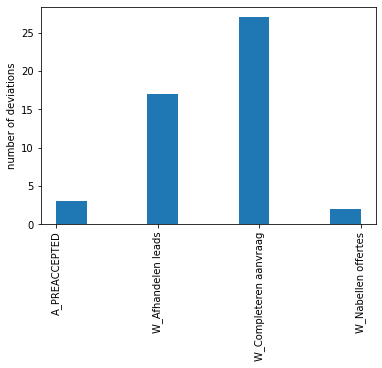

In [14]:
import matplotlib.pyplot as plt

deviations = []

for alignment in alignments.values():
    deviations.extend([x[0] for x in alignment[0] if x[1] == '>>'])
    deviations.extend([x[1] for x in alignment[0] if x[0] == '>>'])

plt.hist(deviations)
plt.xticks(rotation='vertical')
plt.ylabel('number of deviations')
plt.show()

## -- End

# **Example from Conformance Checking Book**
---
---

In [16]:
from pmlab_lite.helper.io import pnml
running_example = PetriNet()
pnml.load(running_example, '/content/conf_tutorial/running_example.pnml')

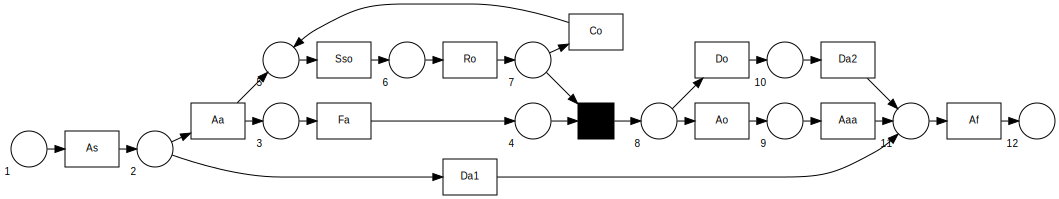

In [17]:
dot.draw_petri_net(running_example)

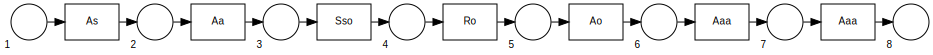

In [18]:
trace = ['As', 'Aa', 'Sso', 'Ro', 'Ao', 'Aaa', 'Aaa']
trace_net = TraceNet(trace)
dot.draw_petri_net(trace_net)

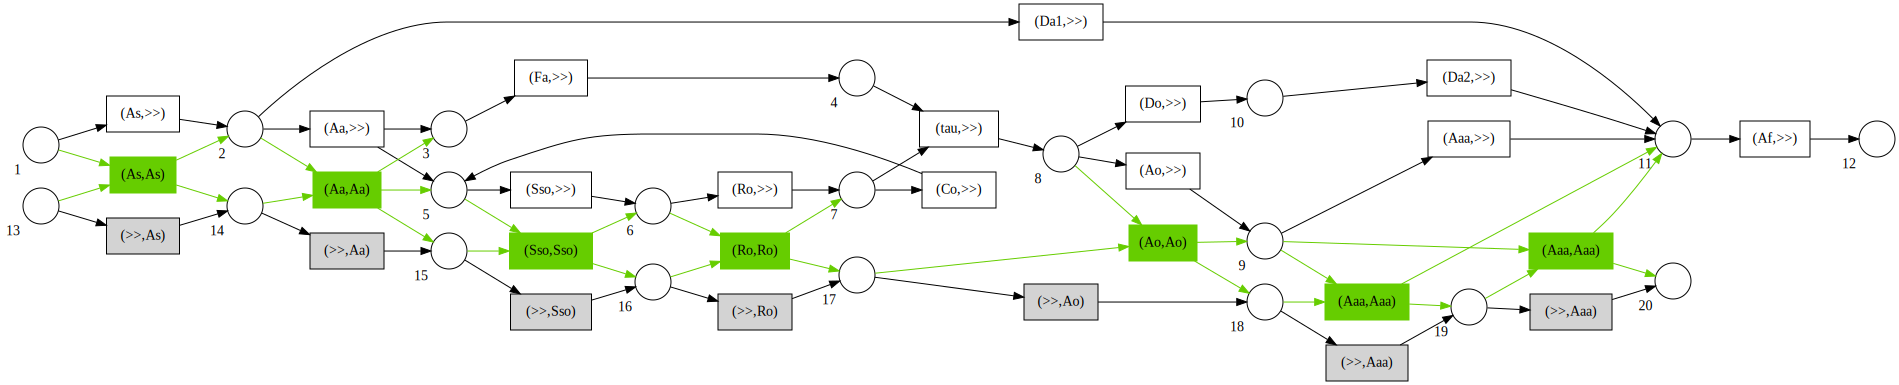

In [19]:
sp = SynchronousProduct(running_example, trace_net)
dot.draw_synchronous_product(sp)

In [20]:
b = A_Star(sp, trace, heuristic='tl')
b.search()
b.print_alignment() 

----------------------------------------------------------------------------
| log trace          | As | Aa | Sso | Ro | Fa | tau | Ao | Aaa | >>  | Af |
----------------------------------------------------------------------------
| execution sequence | As | Aa | Sso | Ro | >> | >>  | Ao | Aaa | Aaa | >> |
----------------------------------------------------------------------------


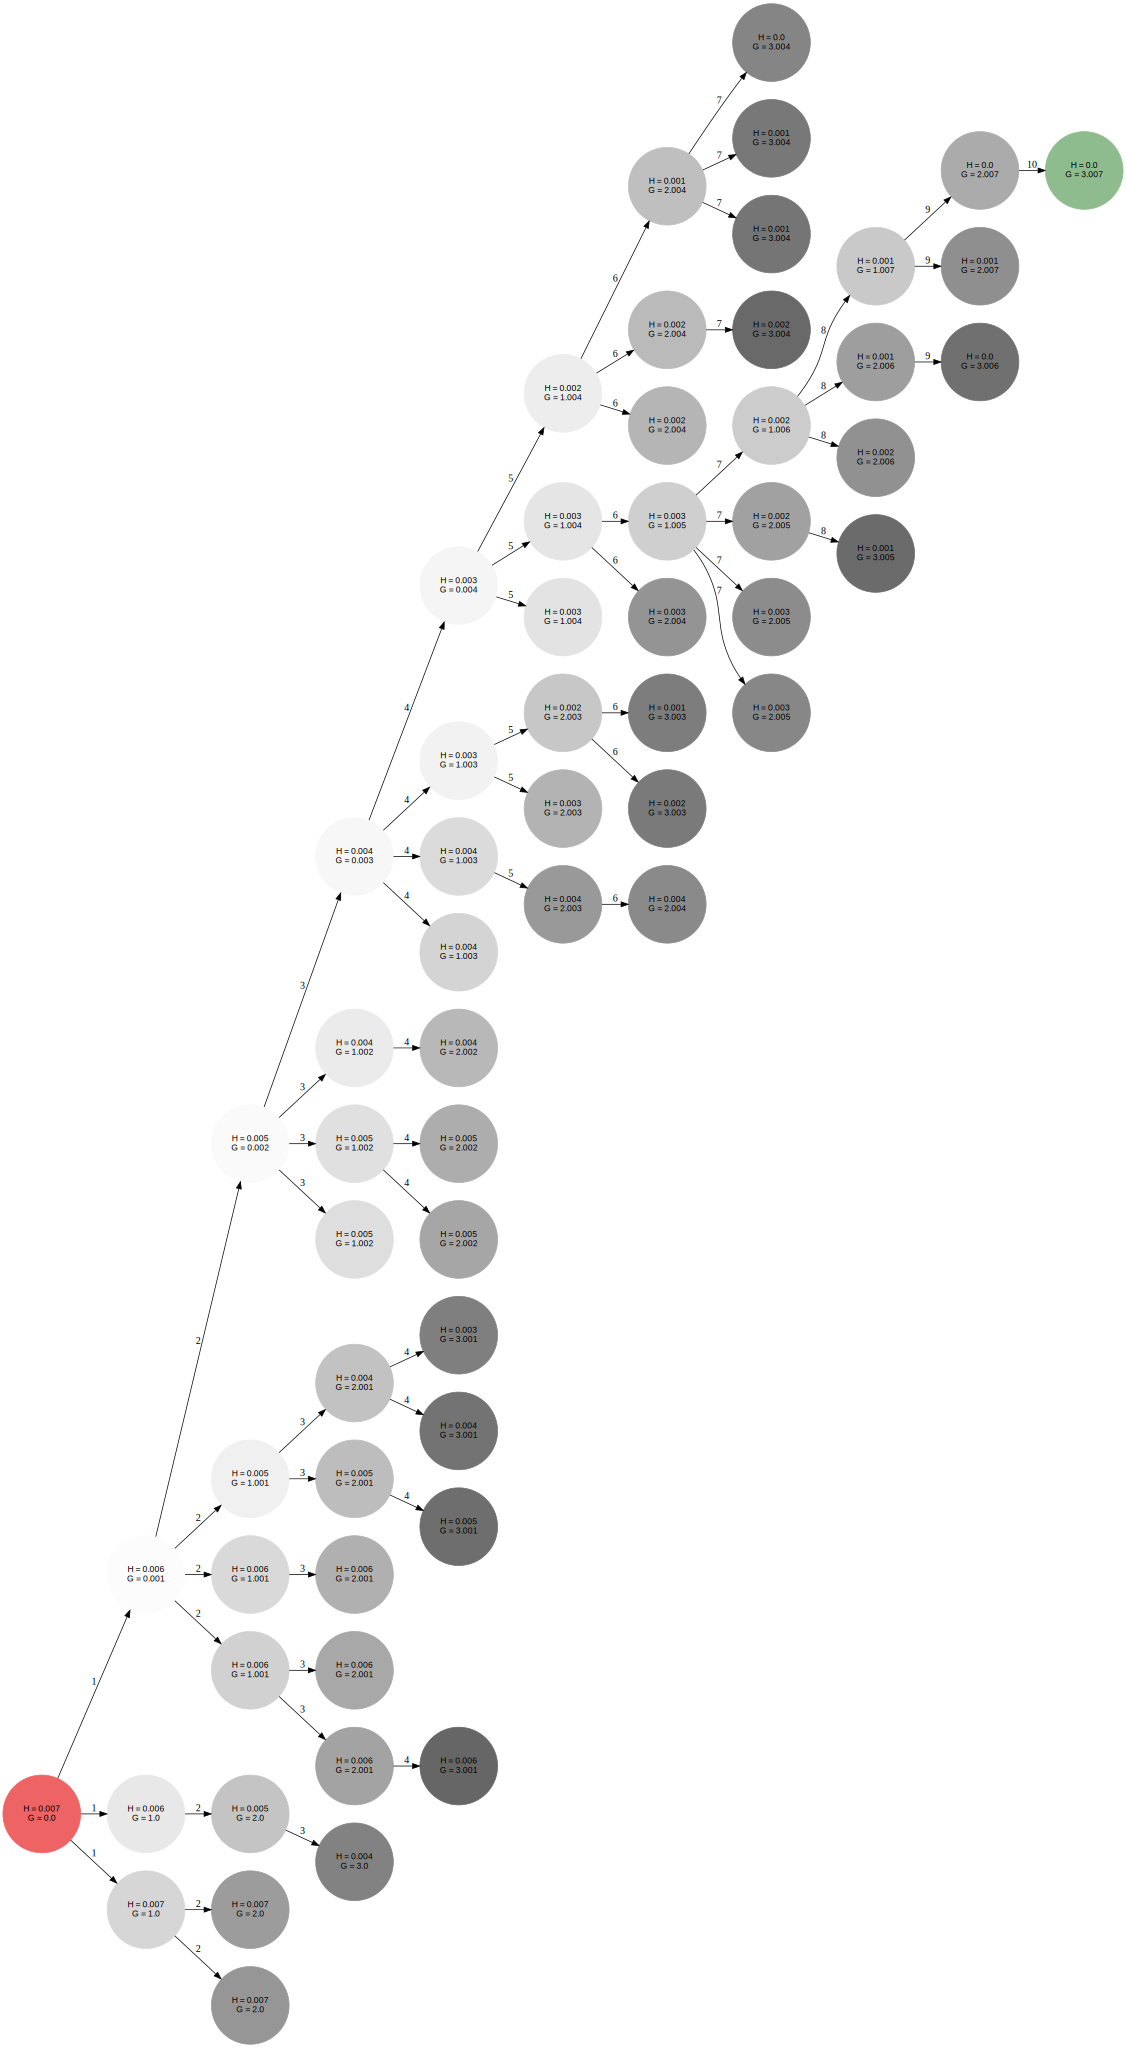

In [21]:
dot.draw_a_star_search_space(b)